#Libraries import

In [1]:
!pip install pydub
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Audio examples


In [ ]:
IPython.display.Audio("/content/drive/MyDrive/event_detection/audio_clips/activates/jarane_1.wav")

In [ ]:
IPython.display.Audio("/content/drive/MyDrive/event_detection/audio_clips/negatives/record (25).wav")

In [ ]:
IPython.display.Audio("/content/drive/MyDrive/event_detection/audio_clips/backgrounds/1.wav")

#Functions to generate one training example

In [3]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
from pydub import AudioSegment

#Generating spectogram
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200
    fs = 8000
    noverlap = 120
    nchannels = data.ndim
    if nchannels == 1:
        pxx, _, _, _ = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, _, _, _ = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx


#Loading .wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

#Loading raw audio examples
def load_raw_audio():
    activates = []
    backgrounds = []
    negatives = []
    for filename in os.listdir("/content/drive/MyDrive/event_detection/audio_clips/activates"):
        if filename.endswith("wav"):
            activate = AudioSegment.from_wav("/content/drive/MyDrive/event_detection/audio_clips/activates/"+filename)
            activates.append(activate)
    for filename in os.listdir("/content/drive/MyDrive/event_detection/audio_clips/backgrounds"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav("/content/drive/MyDrive/event_detection/audio_clips/backgrounds/"+filename)
            backgrounds.append(background)
    for filename in os.listdir("/content/drive/MyDrive/event_detection/audio_clips/negatives"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav("/content/drive/MyDrive/event_detection/audio_clips/negatives/"+filename)
            negatives.append(negative)
    return activates, negatives, backgrounds

Tx = 5511
n_freq = 101
Ty = 1375

activates, negatives, backgrounds = load_raw_audio()

#Generating random segments for making training example
def get_random_time_segment(segment_ms):

    segment_start = np.random.randint(low=0, high=10000-segment_ms)
    segment_end = segment_start + segment_ms - 1

    return (segment_start, segment_end)

#Testing if segments are overlapping
def is_overlapping(segment_time, previous_segments):
    segment_start, segment_end = segment_time

    overlap = False

    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
            break
    return overlap

#Inserting clips
def insert_audio_clip(background, audio_clip, previous_segments):
    segment_ms = len(audio_clip)
    segment_time = get_random_time_segment(segment_ms)
    retry = 5
    while is_overlapping(segment_time, previous_segments) and retry >= 0:
        segment_time = get_random_time_segment(segment_ms)
        retry = retry - 1

    if not is_overlapping(segment_time, previous_segments):
        previous_segments.append(segment_time)
        new_background = background.overlay(audio_clip, position = segment_time[0])
    else:
        new_background = background
        segment_time = (10000, 10000)

    return new_background, segment_time

#Labeling y vector
def insert_ones(y, segment_end_ms):
    _, Ty = y.shape
    segment_end_y = int(segment_end_ms * Ty / 10000.0)

    if segment_end_y < Ty:
        for i in range(segment_end_y+1, segment_end_y+51):
            if i < Ty:
                y[0, i] = 1

    return y

#Generating 10s training example
def create_training_example(background, activates, negatives, Ty):
    y = np.zeros((1, Ty))

    previous_segments = []

    #Random positive audios
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]

    for random_activate in random_activates:
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        segment_start, segment_end = segment_time
        y = insert_ones(y, segment_end)

    #Random negative audios
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    for random_negative in random_negatives:
        background, _ = insert_audio_clip(background, random_negative, previous_segments)

    background = match_target_amplitude(background, -20.0)


    file_handle = background.export("train" + ".wav", format="wav")
    preprocess_audio('train.wav')
    x = graph_spectrogram("train.wav")

    return x, y


#Preprocessing audio
def preprocess_audio(filename):
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    segment = segment.set_frame_rate(44100)
    segment.export(filename, format='wav')

#Generating dataset

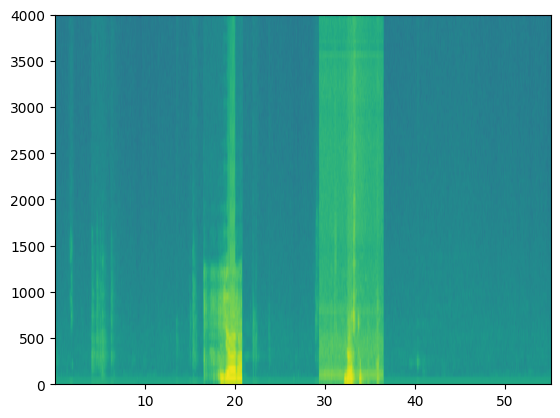

In [ ]:
#Generating 623 examples for training
nsamples = 623
X = []
Y = []
for i in range(0, nsamples):
    x, y = create_training_example(backgrounds[i % 2], activates, negatives, Ty)
    X.append(x.swapaxes(0,1))
    Y.append(y.swapaxes(0,1))
X = np.array(X)
Y = np.array(Y)

np.save('/content/drive/MyDrive/event_detection/X.npy', X)
np.save('/content/drive/MyDrive/event_detection/Y.npy', Y)

#Model

In [ ]:
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, TimeDistributed, Conv1D
from keras.layers import GRU, BatchNormalization

def model(input_shape):

    X_input = Input(shape = input_shape)

    X = Conv1D(196, 15, strides=4)(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(0.2)(X)

    X = GRU(units = 128, return_sequences=True)(X)
    X = Dropout(0.2)(X)
    X = BatchNormalization()(X)

    X = GRU(units = 128, return_sequences=True)(X)
    X = Dropout(0.2)(X)
    X = BatchNormalization()(X)

    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)

    model = Model(inputs = X_input, outputs = X)

    return model

model = model(input_shape = (Tx, n_freq))

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5511, 101)]       0         
                                                                 
 conv1d (Conv1D)             (None, 1375, 196)         297136    
                                                                 
 batch_normalization (Batch  (None, 1375, 196)         784       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 1375, 196)         0         
                                                                 
 dropout (Dropout)           (None, 1375, 196)         0         
                                                                 
 gru (GRU)                   (None, 1375, 128)         125184    
                                                             

##Loading dataset

In [ ]:
import numpy as np

X_tr = np.load('/content/drive/MyDrive/event_detection/X.npy')
Y_tr = np.load('/content/drive/MyDrive/event_detection/Y.npy')

##Model training

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow as tf

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train, X_val, Y_train, Y_val = train_test_split(np.array(X), np.array(Y), test_size=0.2)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5)

model_checkpoint = ModelCheckpoint('RNN_best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

model.fit(X_train, Y_train, batch_size=16, epochs=50, validation_data=(X_val, Y_val), callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 0.7233 - accuracy: 0.5802
Epoch 1: val_loss improved from inf to 0.51209, saving model to nebitno_RNN_best_model.h5
32/32 [==============================] - 20s 197ms/step - loss: 0.7233 - accuracy: 0.5802 - val_loss: 0.5121 - val_accuracy: 0.9351
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - ETA: 0s - loss: 0.5420 - accuracy: 0.7878
Epoch 2: val_loss improved from 0.51209 to 0.39841, saving model to nebitno_RNN_best_model.h5
32/32 [==============================] - 4s 138ms/step - loss: 0.5420 - accuracy: 0.7878 - val_loss: 0.3984 - val_accuracy: 0.9351
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 0.3894 - accuracy: 0.8858
Epoch 3: val_loss improved from 0.39841 to 0.30567, saving model to nebitno_RNN_best_model.h5
32/32 [==============================] - 5s 155ms/step - loss: 0.3894 - accuracy: 0.8858 - val_loss: 0.3057 - val_accuracy: 0.9351
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.9275
Epoch 4: val_loss improved from 0.30567 to 0.22201, saving model to nebitno_RNN_best_model.h5
32/32 [==============================] - 4s 130ms/step - loss: 0.2646 - accuracy: 0.9275 - val_loss: 0.2220 - val_accuracy: 0.9395
Epoch 5/50
32/32 [==============================] - ET

#Testing model

In [4]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/event_detection/RNN_best_model (4).h5')

In [5]:
def detect_triggerword(x, model):
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)

    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

chime_file = "/content/drive/MyDrive/event_detection/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    consecutive_timesteps = 0
    for i in range(Ty):
        consecutive_timesteps += 1
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            consecutive_timesteps = 0

    audio_clip.export("prediction.wav", format='wav')

##Generating audio for testing

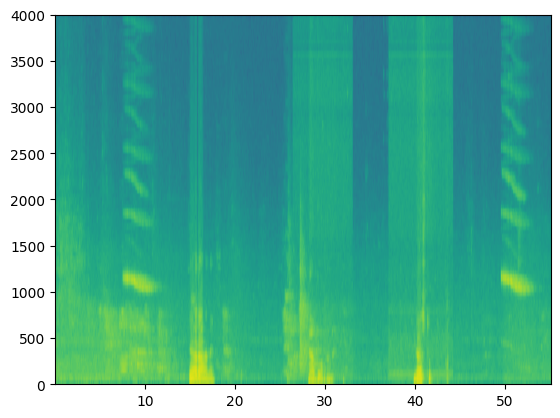

In [11]:
x, y = create_training_example(backgrounds[1], activates, negatives, Ty)
IPython.display.Audio("train.wav")


##Labeling example

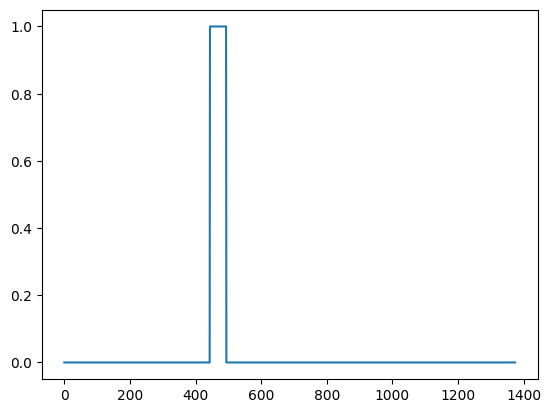

In [12]:
plt.plot(y[0])

##Testing model with audio

1/1 [==============================] - 3s 3s/step


<ipython-input-5-53b0f3a4915b>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 2)


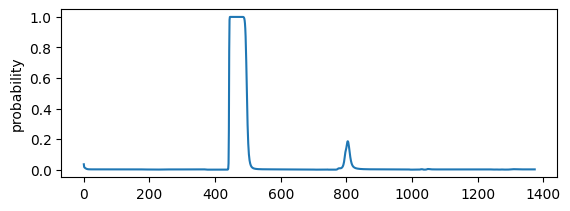

In [13]:
filename = "train.wav"
preprocess_audio(filename)
x=graph_spectrogram(filename)
prediction = detect_triggerword(x, model)
chime_on_activate(filename, prediction, 0.6)
IPython.display.Audio("./prediction.wav")